# Advanced Matplotlib Plotting

By the end of this tutorial, you'll know how to produce and customize a number of different graphics types using Matplotlib.

## Required Preparation

 - Go over the [Lecture 3](https://robertsj.github.io/me400_notes/lectures/Basic_Data_Processing_with_NumPy_and_Matplotlib.html) and [Lecture 4](https://robertsj.github.io/me400_notes/lectures/More_on_NumPy_Arrays.html) notes from ME 400 on Matplotlib (and NumPy)
 - Skim the examples at the [Matplotlib Gallery](https://matplotlib.org/3.1.1/gallery/index.html)

## Case Study Data

To help illustrate some of the capabilities of `matplotlib` for two-dimensional visualization, I'm going to use some freely available data.  The following should get everything loaded:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas 
import os
import urllib.request

if not os.path.isfile('./covid.csv'):
    urllib.request.urlretrieve("https://api.covidtracking.com/v1/states/daily.csv", "./covid.csv")
covid = pandas.read_csv('./covid.csv')
# by default, date is a number like 20201030.  Use datetime
# to turn that into one integer that represents the number
# of days since the "epoch" (January 1, 1970)
from datetime import date
todate = lambda x: (date(*(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]))).toordinal())
days = np.array(list(map(todate, covid.date)))
days = days - min(days)
covid['days'] = days 
cycling = pandas.read_csv('./cycling.csv')

## Simple Lines

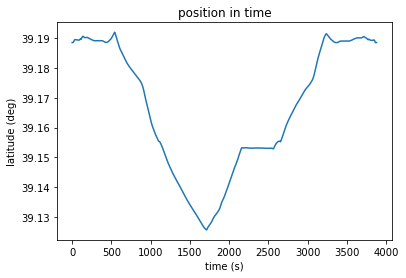

In [3]:
time = cycling.time # time in seconds 
y = cycling.latitude # latitude (in degrees)
plt.figure(1) # we can number figures so they don't overwrite, etc.
plt.plot(time, y, '-')
plt.title('position in time')
plt.xlabel('time (s)')
plt.ylabel('latitude (deg)');

We also have the longitude.  How do we show both? We can plot both versus time like

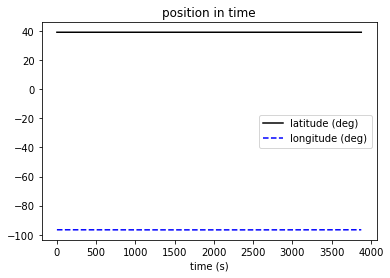

In [4]:
x = cycling.longitude # latitude (in degrees)
plt.figure(2)
plt.plot(time, y, 'k', time, x, 'b--')
plt.title('position in time')
plt.xlabel('time (s)')
plt.legend(['latitude (deg)', 'longitude (deg)']);

That is a horrible representation since both lines look flat!  We *could* scale these by their mean values, e.g., plot `y/np.mean(y)`, but that adds another step for the viewer to process.

 To retain the shape (and value) of both curves, we'll need two axes.  To differentiate the curves, we'll need the legend again or, here, we'll make it obvious which curve goes with which vertical axis.

<Figure size 432x288 with 0 Axes>

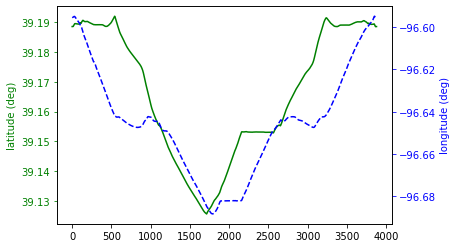

In [5]:
plt.figure(3)
fig, ax_lat = plt.subplots()
ax_lat.plot(time, y, 'g')
ax_lat.set_ylabel('latitude (deg)', color='g')
ax_lat.tick_params(axis='y', colors='g');
ax_lon = ax_lat.twinx() # create new y axis with same x values
ax_lon.plot(time, x, 'b--')
ax_lon.set_ylabel('longitude (deg)', color='b');
ax_lon.tick_params(axis='y', colors='b');
# optionally save the figure
plt.savefig('latlon.png');

## 2-D Viz

The data also includes the elevation for this particular ride.  Although the ride covered just a small part of the area, we can estimate the altitude everywhere using interpolation.  Here, linear or polynomial interpolation would probably be a terrible option, as would be a regression model.  Instead, we'll use approximate radial-basis-function (RBF) interpolation with some artificial smoothing (it makes the fit nicer):

In [11]:
z = cycling.altitude
from scipy.interpolate import Rbf
rbfi = Rbf(x, y, z, smooth=0.001)


How good does this interpolator reproduce our altitudes as recorded?  Check for yourself!

Now, let's produce the altitudes everywhere and plot the gradient of those altitudes:

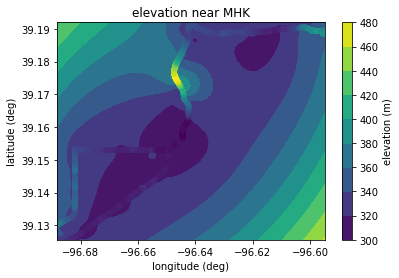

In [13]:
bb = [min(x), max(x), min(y), max(y)]
xp = np.linspace(min(x), max(x),100)
yp = np.linspace(min(y), max(y),100)
xx, yy = np.meshgrid(xp, yp)
zz = rbfi(xx, yy)
plt.figure(4)
plt.contourf(xx, yy, zz)
cbar = plt.colorbar()
cbar.ax.set_ylabel('elevation (m)')

# place the actual data on top.  change cmap to viridis
# for equivalent colors
plt.scatter(x, y, c=z, cmap='viridis', s=20);

plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.title('elevation near MHK');

How could we get the true elevation data?  How about more information about the route?

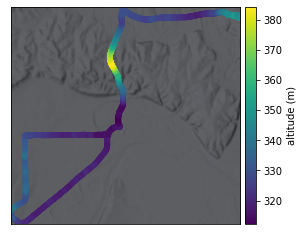

In [15]:
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

plt.figure(5)
M = Basemap(projection='cyl', epsg=6923,
            llcrnrlat=min(y), llcrnrlon=min(x),
            urcrnrlat=max(y), urcrnrlon=max(x), resolution='c')
M.arcgisimage(service='Elevation/World_Hillshade_Dark', xpixels=1000)
xM, yM = M(np.array(x), np.array(y))
M.scatter(xM, yM, c=z, cmap='viridis', s=20)
M.colorbar().set_label('altitude (m)')

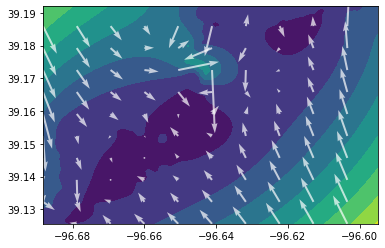

In [16]:
plt.figure(6)
plt.contourf(xx, yy, zz)
dzdx, dzdy = np.gradient(zz, xp, yp)
skip=10
plt.quiver(xx[::skip,::skip], yy[::skip,::skip], 
           dzdx[::skip,::skip], dzdy[::skip,::skip], color='white', alpha=0.7)

## Other Data: Errors and Beyond

We're all dealing with COVID-19, and there is so much data out there that it's hard to know what to do with it.  With some basic graphics, it's easy to understand some of the features of the disease's spread.  For legal reasons, this is just a joke.

Let's take a look at some basic numbers for KS.  We can look at the dataframe directly.  Also, the `keys` method returns all the column names.  Here, we pick out `positives` and `positiveIncrease`, which are the total number of positives recorded through a given day and the net number of new positive cases on that day (they should be related!).

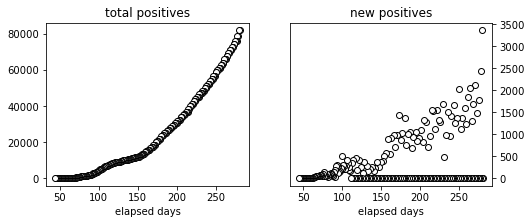

In [19]:
# Extract KS data
ks = covid[covid.state=="KS"] # nice, eh?
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(8,3))
ax0.plot(ks.days, ks.positive, 'ko', mfc='w')
ax0.set_xlabel('elapsed days')
ax0.set_title('total positives')
ax1.plot(ks.days, ks.positiveIncrease, 'ko', mfc='w')
ax1.yaxis.set_ticks_position("right")
ax1.set_xlabel('elapsed days')
ax1.set_title('new positives');

Cool. What the heck does this mean?  You might remember something about growth rates, etc., in media and elsewhere.  Basically, population growth is exponential and can be described by the simpled ODE you'd like to forget:

$$
   \frac{dn(t)}{dt} = r(n(t), N(t), t) \approx \alpha n(t) \, .
$$

In reality, the number of positives $n(t)$ should depend on itself (i.e., you can't get positive again) and on the number of people $N(t)$.  All of this depends on time. The complicated mess is hidden in $r(n, N, t)$ and could be totally right but is totally impossible to write down with confidence.  However, if we assume $N$ is pretty large (relative to $n$) and constant and that people are sort of mixed uniformly, and that things like weather, football games, etc., affect nothing, that the change in positives per unit time ought to be proportional to N.  Then 

$$
  n(t) \propto e^{\alpha t} \, .
$$

Based on units alone, $\alpha$ must be a probability per existing person per unit time of becoming infected.  The growth rate $r$ is defined by the ratio $(1+r) = n(t)/n(t-1) = e^{\alpha}$.  If $\alpha = 0$, $r = 0$, and nobody gets sick.  We we are *doubling* positives per day, i.e., $n(t)/n(t-1) = 2$, then $r=1$, and we have a 100% increase per day.  Bad news.  So what do we observe?

To estimate this growth rate, we need to fit the model $p(t) = p(0) e^{\alpha t}$ to the data.  Our old trick linear regression works here if we use the *logarithm* of $p$, leading to $\log(p(t)) = \log(p(0)) + \alpha t$.  Note that we didn't have cases until a while after it all started, so I've got to modify my inputs a bit:

In [20]:
p = np.array(ks.positive[ks.positive>0])
t = np.array(ks.days[ks.positive>0])
alpha, log_p_0 = np.polyfit(t, np.log(p),deg=1) # or np.linalg.lstsq(np.array([t**1, t**0]).T, np.log(p))
r = np.exp(alpha)-1
r 

0.0296647440712956

That's a 3% growth rate.  Does it fit the data well?

<Figure size 432x288 with 0 Axes>

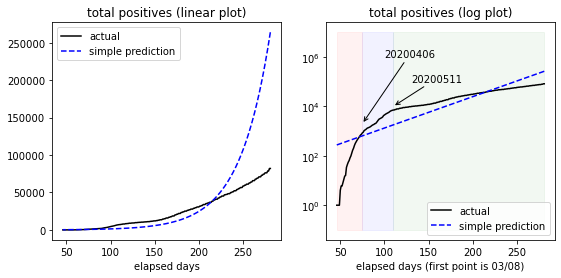

In [22]:
plt.figure(5)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(9,4))

ax0.plot(t, p, 'k-', t, np.exp(alpha*t + log_p_0), 'b--')
ax0.set_xlabel('elapsed days')
ax0.set_title('total positives (linear plot)')
ax0.legend(['actual', 'simple prediction'])

ax1.semilogy(t, p, 'k-', t, np.exp(alpha*t + log_p_0), 'b--')
ax1.fill_betweenx([1e-1, 1e7], min(t), 75, alpha=0.05, color="red")
ax1.fill_betweenx([1e-1, 1e7], 75, 110, alpha=0.05, color='blue')
ax1.fill_betweenx([1e-1, 1e7], 110, max(t), alpha=0.05, color='green')
date0 = str(list(covid.date[covid.days==(75)])[0])
date1 = str(list(covid.date[covid.days==(110)])[0])
ax1.annotate(date0, xy=(75,2e3), xytext=(100, 1e6), arrowprops={'arrowstyle': '->'})
ax1.annotate(date1, xy=(110,1e4), xytext=(130, 1e5), arrowprops={'arrowstyle': '->'})
ax1.set_xlabel('elapsed days (first point is 03/08)')
ax1.set_title('total positives (log plot)')
ax1.legend(['actual', 'simple prediction'],loc=4);

Well, thankfully we're not seeing that sort of growth!    What could be off about our model?  We are not accounting for a variety of variables that probably impact the observed growth.  From a modeling standpoint, we could try to account for thos aspects by treating $\alpha$ as a time-varying quantity (e.g., more masks probably lead to lower $\alpha$).  If we want $\alpha(t) = \alpha_0 + \alpha_1 t + \alpha_2 t^2 + \ldots$, we just need a higher degree polynomial for our fit above.  But to the right, I've highlighed three regions in each of which the growth appears to be somewhat constant.  Those dates correspond to 04/06 and 05/11.  For reference, the stay-home order was given 3/30, and "Phase 1" went live on 5/4.  Finals were the week of 5/13. Let's repeat this using *just the last* region of highlighted data and let $\alpha = \alpha_0 + \alpha_1 t$.

<Figure size 432x288 with 0 Axes>

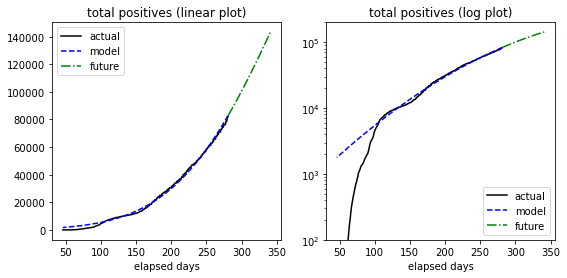

In [24]:
t_region = t[t > 110]
p_region = p[t > 110]
coefs = np.polyfit(t_region, np.log(p_region),deg=2) # deg = 2 for linear alpha
t_future = range(max(t_region), max(t_region)+61)
p_appx = np.exp(np.polyval(coefs, t))
p_future = np.exp(np.polyval(coefs, t_future))

plt.figure(6)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(9,4))
ax0.plot(t, p, 'k-', t, p_appx, 'b--', t_future, p_future, 'g-.')
ax0.set_xlabel('elapsed days')
ax0.set_title('total positives (linear plot)')
ax0.legend(['actual', 'model', 'future'])

ax1.semilogy(t, p, 'k-', t, p_appx, 'b--', t_future, p_future, 'g-.')
ax1.set_xlabel('elapsed days')
ax1.set_title('total positives (log plot)')
ax1.set_ylim((1e2, 2e5))
ax1.legend(['actual', 'model', 'future'],loc=4);

So how *good* is this model?  There's a lot of ways to quantify how far off our predictions could be, but a cool trick is called the bootstrap method.  Basically, to make that model, we used $N$ unique pairs of times and positives.  Bootstrapping takes those $N$ points, randomly selects $N$ new points, allowing repeated copies, and then refits the data.  By doing this over and over $M$ times, the resulting fits and predictions have spread that we can easily quantify (or visualize).

<Figure size 432x288 with 0 Axes>

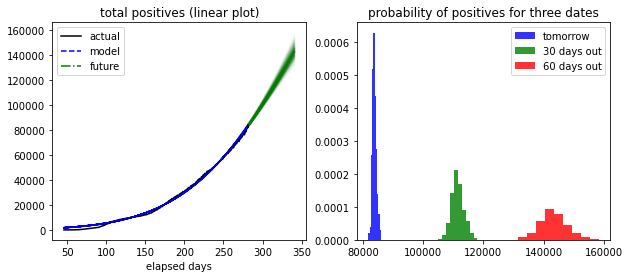

In [25]:
M = 500
N = len(t_region)
c_samples = []
p_future_samples = []

plt.figure(7)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,4))
ax0.plot(t, p, 'k-', t, p_appx, 'b--', t_future, p_future, 'g-.')
ax0.set_xlabel('elapsed days')
ax0.set_title('total positives (linear plot)')
ax0.legend(['actual', 'model', 'future'])

np.random.seed(1234)

for i in range(M):
    idx = np.random.randint(low=0, high=N, size=N)
    t_sample = t_region[idx]
    p_sample = p_region[idx]
    c_samples.append(np.polyfit(t_sample, np.log(p_sample), deg=2))
    
    appx = np.exp(np.polyval(c_samples[-1], t))
    appx_future = np.exp(np.polyval(c_samples[-1], t_future))
    p_future_samples.append(appx_future)
    ax0.plot(t, appx, 'b', alpha=0.01)
    ax0.plot(t_future, appx_future, 'g', alpha=0.01)

ax1.set_title('probability of positives for three dates')
ax1.hist(np.array(p_future_samples)[:, 1], density=True, color='b', alpha=0.8)
ax1.hist(np.array(p_future_samples)[:, 30], density=True, color='g', alpha=0.8)
ax1.hist(np.array(p_future_samples)[:,  60], density=True,color='r', alpha=0.8)
ax1.legend(['tomorrow', '30 days out', '60 days out'])

## Exercises

**A challenge!**  Consider the following contour plot (from D.S. McGregor et al. NIM A 343 (1994)):

<img src="mcgregor.png" alt="drawing" width="400"/>


In [ ]:
def Q(rho_e, rho_h) :
    return rho_e + rho_e**2*(np.exp(-1.0/rho_e)-1.0) + \
           rho_h + rho_h**2*(np.exp(-1.0/rho_h)-1.0)
    
def sig_Q(rho_e, rho_h) :
    a = rho_e**2 + 2.*rho_e**3*(np.exp(-1.0/rho_e)-1) + \
        0.5*rho_e**3*(1-np.exp(-2.0/rho_e))
    b = rho_h**2 + 2.*rho_h**3*(np.exp(-1.0/rho_h)-1) + \
        0.5*rho_h**3*(1-np.exp(-2.0/rho_h))
    c = 2.*rho_e*rho_h + 2.*rho_e**2*rho_h*(np.exp(-1.0/rho_e)-1) + \
        2.*rho_h**2*rho_e*(np.exp(-1.0/rho_h)-1)
    d = 2.*(rho_e*rho_h)**2/(rho_e-rho_h)*(np.exp(-1.0/rho_e)-np.exp(-1.0/rho_h))
    return np.sqrt( a+b+c+d-Q(rho_e,rho_h)**2)
   
def R(rho_e, rho_h) :
    return 100*sig_Q(rho_e, rho_h)/Q(rho_e, rho_h)

In [ ]:
n = 100
H = np.logspace(-2, 2, n)
E = np.logspace(-2, 2, n) 

H, E = np.meshgrid(H, E, sparse=False, indexing='ij')
res = R(E, H)

plt.figure(1, figsize=(6,6))
plt.contour(np.log10(E), np.log10(H), res, colors='k')
plt.axis('equal')


Things that need fixin':

   - *appropriate axis labels* (e.g., `Electron Extraction Factor')
   - correct contour levels (i.e., 0.1, 0.2, 0.5, 1%, and so on).
     Hint: look up the documentation for `plt.contour`.
   - *correct $x$  and $y$ tick values* (e.g., -1 should be 0.1 and 2
       should be 100). Hint: look up, e.g.,`plt.xticks`.
   - *annotations for each contour line*. Hint: look up 
       `plt.text`, paying specific attention to `fontsize`,
      `horizontalalignment`, and `verticalalignment`. 
       You might also which to consider using `scipy.optimize.newton`
       to help you automatically find where text should be located,
       e.g., you know that the upper-left 40\% box should be located where 
       $F(x) = 100 - R(\rho_e, 100) = 0$.  However, you may simply
       place each text annotation manually.
   - *logarithmic minor tick marks*.   Note the 
       original has minor tick marks spaced logarithmically, whereas
       my solution has no minor tick marks.  Hint: look 
       up `plt.gca().yaxis`.

I had these installed to run this whole thing:

```
matplotlib                3.2.2                         1    conda-forge
matplotlib-base           3.2.2            py38h5d868c9_1    conda-forge
basemap                   1.3.0            py38hee755e7_0    anaconda
basemap-data-hires        1.2.2                         0    conda-forge
numpy                     1.19.2           py38hf89b668_1    conda-forge
```